<a href="https://colab.research.google.com/github/Rohithkonuru/NEURAL-STYLE-TRANSFER/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving download (1).jpeg to download (1) (1).jpeg
Saving download.jpeg to download (2).jpeg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 153MB/s]


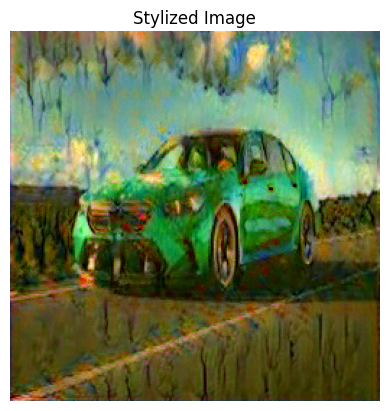

In [2]:
!pip install torch torchvision pillow matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loader = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def image_loader(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    if title: plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

from google.colab import files
uploaded = files.upload()


content_img = image_loader("download (2).jpeg")
style_img = image_loader("download (1) (1).jpeg")



cnn = models.vgg19(pretrained=True).features.to(device).eval()


class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

def get_style_model_and_losses(cnn, style_img, content_img):
    cnn = cnn.to(device).eval()

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    content_losses = []
    style_losses = []
    model = nn.Sequential()

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

input_img = content_img.clone()

def run_style_transfer(cnn, style_img, content_img, input_img, num_steps=50,
                       style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            run[0] += 1
            return loss
        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

output = run_style_transfer(cnn, style_img, content_img, input_img, num_steps=50)
imshow(output, title='Stylized Image')